# ロスカット分析（サマリ）

### プロジェクトのルートのパスを通す

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリを一括インポート

In [2]:
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from funcs.tide import get_date_str_from_file
from funcs.tse import get_ticker_name_list
from structs.res import AppRes

### Matplotlib のフォント設定（オプション）

In [3]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

## CSV ファイル（取引明細）読み込み

In [4]:
res = AppRes()

code = "7011"  # 銘柄コード
# code = "8306"  # 銘柄コード


dict_name = get_ticker_name_list([code])
print(dict_name)

list_doe = [
    "lc_00",
    "lc_05",
    "lc_10",
    "lc_15",
    "lc_20",
    "lc_25",
    "lc_30",
    "lc_35",
    "lc_40",
    "lc_45",
    "lc_50",
]

dict_losscut = dict()
dict_losscut["loss cut"] = list()
dict_losscut["profit"] = list()

pattern = re.compile(r"lc_(\d{2})")
for doe in list_doe:
    if m := pattern.match(doe):
        level = int(m.group(1)) * -1
    else:
        level = +1

    dir_transaction = os.path.join("..", res.dir_transaction, code, doe)
    list_file = sorted(os.listdir(dir_transaction))
    date_str = get_date_str_from_file(list_file[-1])
    # print(date_str)

    # print("\n分析対象の取引明細ファイル")
    # print(list_file)
    n_day = len(list_file)
    # print(f"# of transaction files : {n_day}")

    list_df = list()
    for file in list_file:
        path_csv = os.path.join(dir_transaction, file)
        df = pd.read_csv(path_csv)
        if len(df) > 0:
            list_df.append(df)
    df_transaction = pd.concat(list_df).dropna(how="any")
    df_transaction.reset_index(inplace=True, drop=True)
    #v_mean = df_transaction["損益"].mean()
    #v_sigma = df_transaction["損益"].std()
    for profit in df_transaction["損益"]:
        dict_losscut["loss cut"].append(level)
        dict_losscut["profit"].append(profit)

df = pd.DataFrame(dict_losscut)
df

{'7011': '三菱重工業'}


,loss cut,profit
0,0,-1.0
1,0,-1.0
2,0,-1.0
3,0,-3.0
4,0,-4.0
...,...,...
7211,-50,4.0
7212,-50,2.0
7213,-50,3.0
7214,-50,3.0


../output/20251225_7011_losscut_summary.png


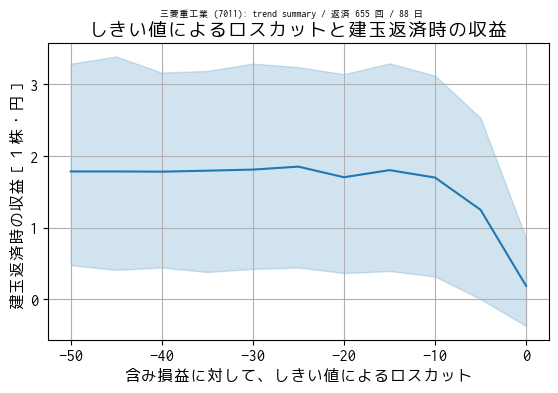

In [5]:
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

sns.lineplot(data=df, x="loss cut", y="profit",)
#sns.regplot(data=df, x="loss cut", y="profit")
ax.grid()
ax.set_title("しきい値によるロスカットと建玉返済時の収益")
ax.set_xlabel("含み損益に対して、しきい値によるロスカット")
ax.set_ylabel("建玉返済時の収益［１株・円］")

plt.tight_layout()

title_scope = (
    "          "
    f"{dict_name[code]} ({code}): "
    f"trend summary / 返済 {len(df_transaction)} 回 / {n_day} 日"
)
plt.suptitle(title_scope, fontsize=7)
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
output = os.path.join("..", "output", f"{date_str}_{code}_losscut_summary.png")
print(output)
plt.savefig(output)
plt.show()